# **Data Import**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings

# Suppress specific openpyxl warnings
warnings.filterwarnings("ignore", category=UserWarning, module="openpyxl")

# Load the Excel file
excel_file_path = '/content/drive/MyDrive/ENGG680_2024_fall/Project_Work/Project_Data.xlsx'  # Replace with your Excel file path

# Read all sheet names
excel_data = pd.ExcelFile(excel_file_path)
sheet_names = excel_data.sheet_names

# Create a dictionary to store DataFrames for each sheet
dataframes = {}

# Loop through each sheet and read it into a DataFrame
for sheet_name in sheet_names:
    df = pd.read_excel(excel_file_path, sheet_name=sheet_name)
    dataframes[sheet_name] = df  # Store the DataFrame in the dictionary

# Print the keys of the dictionary to show the classified dataframes
print("Loaded sheets and their respective DataFrames:")
for sheet_name in dataframes:
    print(f"Sheet: {sheet_name}, DataFrame shape: {dataframes[sheet_name].shape}")

# Print the DataFrame
    #print(f"Data from sheet: {sheet_name}")
    #print(df)


Loaded sheets and their respective DataFrames:
Sheet: Details & Criteria Definition, DataFrame shape: (30, 66)
Sheet: Input Data, DataFrame shape: (2453, 7)


# **Input Data Inspection**
To plot the histogram for each parameter to visualise class imbalance. The code displays you the exact value of the samples for each class above the respective bins.

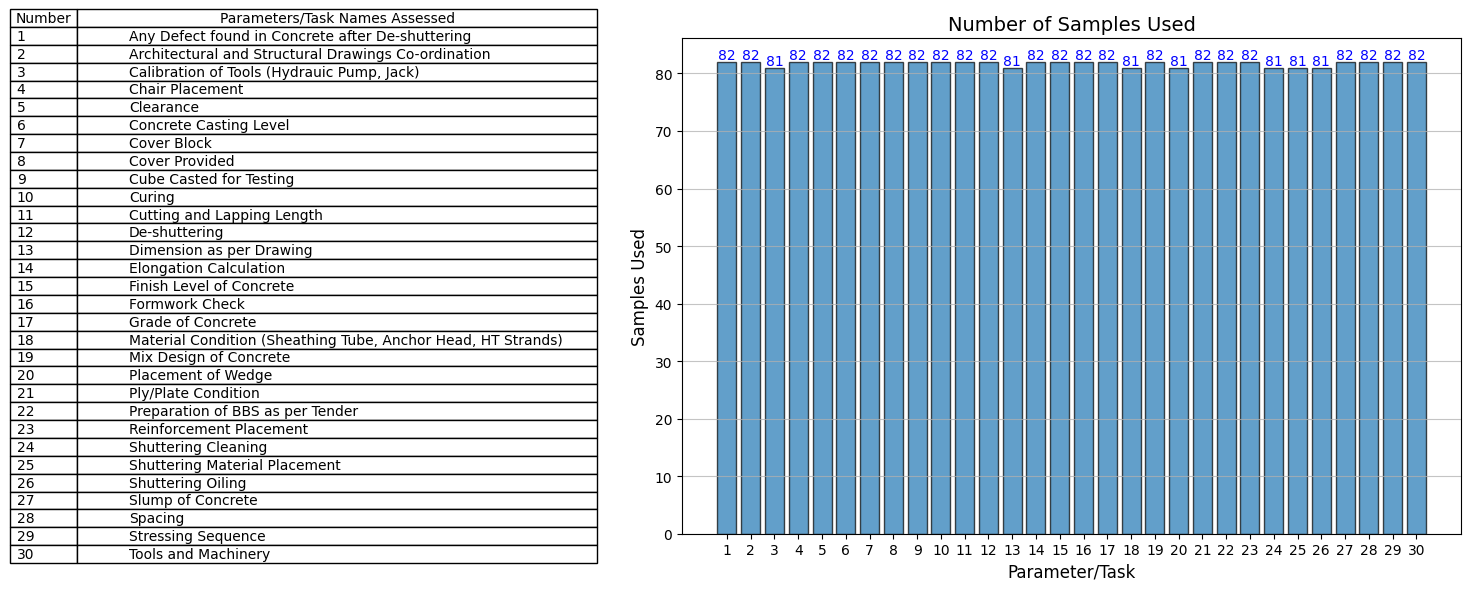

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# Load specific column C from sheet 1 for table
data_table = pd.read_excel(excel_file_path, sheet_name=1, usecols=[2])  # C is column 2 (zero-indexed)
data_table.columns = ['C']  # Rename column for clarity

# Drop rows with missing values
data_table = data_table.dropna()

# Count occurrences of each unique value in column C
class_counts_table = data_table['C'].value_counts().sort_index()

# Create a DataFrame for the unique values and numbering
unique_values = pd.DataFrame({'Number': range(1, len(class_counts_table) + 1),
                              'Parameters/Task Names Assessed': class_counts_table.index})
#------------------------------------------------------------------------------------------------------------------------
# Load specific columns C and E from sheet 1 for histogram
data_hist = pd.read_excel(excel_file_path, sheet_name=1, usecols=[2, 4])  # C is column 2, E is column 4 (zero-indexed)
data_hist.columns = ['C', 'E']  # Rename columns for clarity

# Drop rows with missing values
data_hist = data_hist.dropna()

# Group data by column C (class label) and count occurrences in column E
class_counts_hist = data_hist.groupby('C')['E'].count()

# Assign order numbers to the unique values in column C for histogram
class_order = {key: idx + 1 for idx, key in enumerate(class_counts_hist.index)}

# Map the order numbers to the X-axis instead of the actual class labels
x_axis_order = [class_order[label] for label in class_counts_hist.index]

# Create a figure with subplots for the table and the histogram
fig, axs = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={'width_ratios': [1, 2]})

# Plot the table on the left
axs[0].axis('tight')
axs[0].axis('off')
table = axs[0].table(cellText=unique_values.values, colLabels=unique_values.columns, loc='center', cellLoc='left')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(unique_values.columns))))

# Plot the histogram on the right
bars = axs[1].bar(x_axis_order, class_counts_hist.values, edgecolor='black', alpha=0.7)

# Annotate the bars with exact counts
for bar, label in zip(bars, class_counts_hist.index):
    height = bar.get_height()
    axs[1].text(bar.get_x() + bar.get_width() / 2, height, str(int(height)),
                ha='center', va='bottom', fontsize=10, color='blue')

# Set X-axis ticks with interval of 1
axs[1].set_xticks(x_axis_order)
axs[1].set_xticklabels(x_axis_order)
axs[1].set_xlabel('Parameter/Task', fontsize=12)
axs[1].set_ylabel('Samples Used', fontsize=12)
axs[1].set_title('Number of Samples Used', fontsize=14)
axs[1].grid(axis='y', alpha=0.75)

# Adjust layout
plt.tight_layout()
plt.savefig("histogram_table.png", dpi=300, bbox_inches='tight')  # Save the plot
plt.show()


# **Computation and Assignment of Quality Assurance Score and Grading**

### **Average Compliance Ratings**

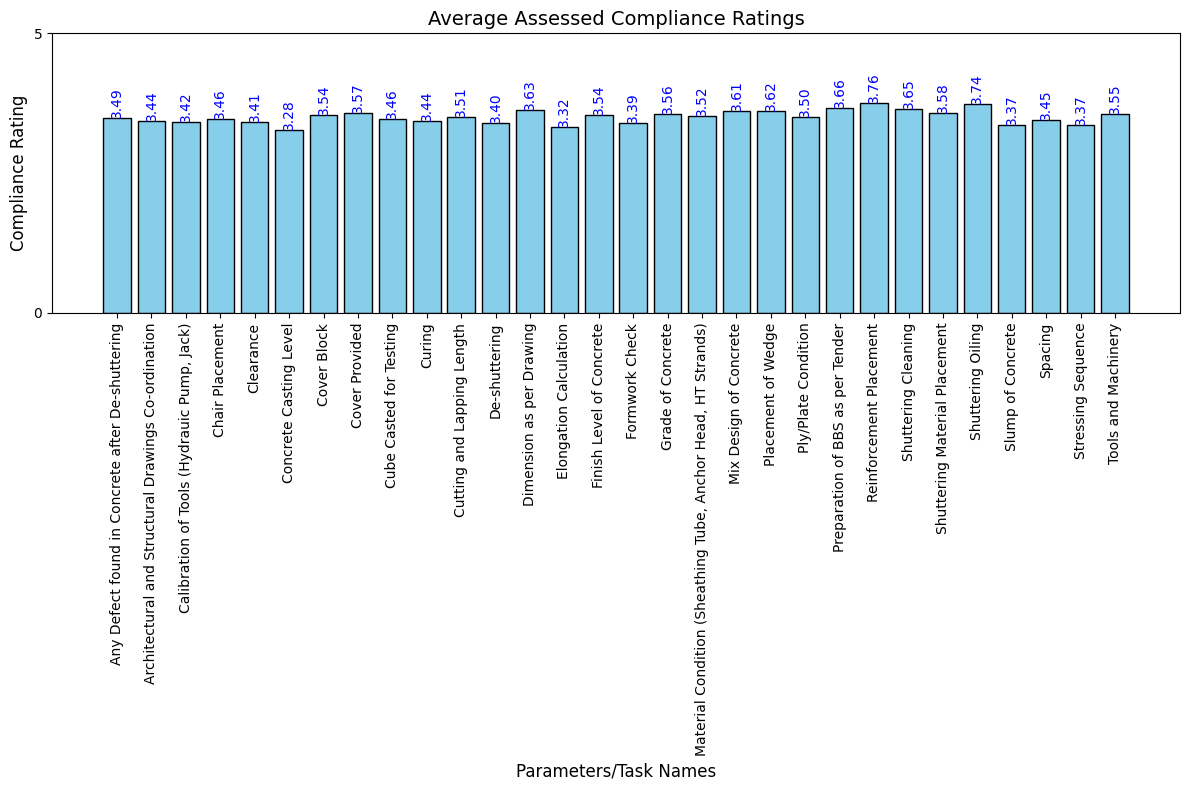

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Load specific columns C and E from sheet 1
data_hist = pd.read_excel(excel_file_path, sheet_name=1, usecols=[2, 4])  # C is column 2, E is column 4 (zero-indexed)
data_hist.columns = ['C', 'E']  # Rename columns for clarity

# Drop rows with missing values
data_hist = data_hist.dropna()

# Plot a bar chart to visualize data in column E against column C
plt.figure(figsize=(12, 8))

# Calculate the mean of column E for each unique value in column C
mean_values = data_hist.groupby('C')['E'].mean()

# Plot the data
bars = plt.bar(mean_values.index, mean_values.values, color='skyblue', edgecolor='black')

# Annotate the bars with exact values and rotate annotations
for bar, value in zip(bars, mean_values.values):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}',
             ha='center', va='bottom', fontsize=10, color='blue', rotation=90)  # Rotated annotations

# Set chart labels and title
plt.xlabel('Parameters/Task Names', fontsize=12)
plt.ylabel('Compliance Rating', fontsize=12)
plt.title('Average Assessed Compliance Ratings', fontsize=14)

# Rotate X-axis labels for better readability
plt.xticks(rotation=90)

# Adjust the Y-axis scale
plt.yticks(range(0, int(max(mean_values.values)) + 5, 5))  # Setting a step size of 5

# Show grid for better visualization
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.savefig('Average Assessed Compliance Ratings.png')  # Save the plot
plt.show()



## **Classification of Parameters According to Main Project Components**

In [5]:
# Process data to classify all values in column F into groups based on column G
# and distribute corresponding column D values equally among group members.

# Load the dataset
data = pd.read_excel(excel_file_path, sheet_name=0, usecols=[5, 6])

# Rename columns for clarity
data.columns = ['F', 'G']

# Drop rows with missing values
data = data.dropna()

# Create a dictionary to group F values by their corresponding G values
groups = {}
for group_label in data['G'].unique():
    # Get all F values corresponding to the current G value
    f_values = data.loc[data['G'] == group_label, 'F'].unique()
    groups[group_label] = f_values.tolist()

# Convert the grouped data to a DataFrame for display
grouped_data = []
for group_label, f_values in groups.items():
    for f_value in f_values:
        grouped_data.append({'Project Component': group_label, 'Parameter': f_value})

grouped_df = pd.DataFrame(grouped_data)

# Print the grouped DataFrame
grouped_df.reset_index(drop=True, inplace=True)
grouped_df.head(1000)

#--------------------------------------------------------------------------------------------

# Split `grouped_df` into separate DataFrames based on unique Group Label (G)

# Create a dictionary to hold separate DataFrames
split_dataframes = {}

# Iterate through unique Group Labels
for group_label in grouped_df['Project Component'].unique():
    # Filter rows belonging to the current group label
    group_df = grouped_df[grouped_df['Project Component'] == group_label]
    # Store the DataFrame in the dictionary
    split_dataframes[group_label] = group_df.reset_index(drop=True)

# Example: Access one of the split DataFrames
for group_label, df in split_dataframes.items():
    print(f"Group Label: {group_label}")
    print(df.head(1000))
    print("\n")

# Split DataFrames are now stored in `split_dataframes` dictionary,
# keyed by their respective Group Labels.

#--------------------------------------------------------------------------------------------

# Code to search for all group labels in column C and compile them with their corresponding values in column D

# Load the dataset
data = pd.read_excel(excel_file_path, sheet_name=0, usecols=[2, 3])

# Rename columns for clarity
data.columns = ['Project Component', 'Project Components Level Weight']

# Drop rows with missing values
data = data.dropna()

# Get unique group labels from column C and their corresponding values in column D
group_labels_df = data[['Project Component', 'Project Components Level Weight']].drop_duplicates().reset_index(drop=True)

# Rename the resulting DataFrame for clarity
group_labels_df.columns = ['Project Component', 'Project Components Level Weight']

# Print the resulting DataFrame
print(group_labels_df.reset_index(drop=True).head(1000))

Group Label: Concreting
   Project Component                                          Parameter
0         Concreting                                  Grade of Concrete
1         Concreting                            Reinforcement Placement
2         Concreting  Architectural and Structural Drawings Co-ordin...
3         Concreting                                     Cover Provided
4         Concreting                                     Formwork Check
5         Concreting                                          Clearance
6         Concreting                             Mix Design of Concrete
7         Concreting                                  Slump of Concrete
8         Concreting                                Tools and Machinery
9         Concreting                           Finish Level of Concrete
10        Concreting                            Cube Casted for Testing
11        Concreting                                      De-shuttering
12        Concreting   Any Defect found 

### **Calculating Parameter Significance (Weights) on Project**

In [6]:
import pandas as pd

# Load the lookup table from Sheet 1 (Columns C and D)
lookup_data = pd.read_excel(excel_file_path, sheet_name=0, usecols=[2, 3])

# Rename columns for clarity
lookup_data.columns = ['Lookup Item', 'Lookup Value']

# Drop rows with missing values
lookup_data = lookup_data.dropna()

# Assuming `split_dataframes` is already created, process each split DataFrame
for group_label, df in split_dataframes.items():
    # Check if the group label exists in the lookup data
    if group_label in lookup_data['Lookup Item'].values:
        # Get the corresponding value from the lookup range
        lookup_value = lookup_data.loc[lookup_data['Lookup Item'] == group_label, 'Lookup Value'].values[0]

        # Divide the lookup value by the total number of rows in the DataFrame
        equal_weight = lookup_value / len(df)

        # Add a new column with the distributed value
        df['Parameter Weight (%)'] = equal_weight*100

# Example: Print one of the updated DataFrames
for group_label, df in split_dataframes.items():
    print(f"Group Label: {group_label}")
    print(df.head(1000))
    print("\n")


Group Label: Concreting
   Project Component                                          Parameter  \
0         Concreting                                  Grade of Concrete   
1         Concreting                            Reinforcement Placement   
2         Concreting  Architectural and Structural Drawings Co-ordin...   
3         Concreting                                     Cover Provided   
4         Concreting                                     Formwork Check   
5         Concreting                                          Clearance   
6         Concreting                             Mix Design of Concrete   
7         Concreting                                  Slump of Concrete   
8         Concreting                                Tools and Machinery   
9         Concreting                           Finish Level of Concrete   
10        Concreting                            Cube Casted for Testing   
11        Concreting                                      De-shuttering   
1

### **Merging All Classes (Dataframes)**

In [7]:
import pandas as pd

# Step 1: Merge all the dataframes in `split_dataframes` into one dataframe
merged_df = pd.concat(split_dataframes.values(), ignore_index=True)

# Step 2: Add a new column to the merged dataframe
merged_df['Average Assessed Compliance Ratings (1-5)'] = None  # Initialize the new column

# Step 3: Load data from Sheet 2 (Columns C and E) and calculate the mean
sheet2_data = pd.read_excel(excel_file_path, sheet_name=1, usecols=[2, 4])  # C is column 2, E is column 4 (zero-indexed)
sheet2_data.columns = ['C', 'E']  # Rename columns for clarity
sheet2_data = sheet2_data.dropna()  # Drop missing values

# Normalize data in Sheet 2 for consistent comparison
sheet2_data['C'] = sheet2_data['C'].astype(str).str.strip().str.lower()
mean_values = sheet2_data.groupby('C')['E'].mean()  # Calculate mean of E for each unique value in C

# Step 4: Normalize the second column of the merged dataframe for comparison
merged_df.iloc[:, 1] = merged_df.iloc[:, 1].astype(str).str.strip().str.lower()

# Step 5: Compare unique values with the second column of the merged dataframe
# and populate the new column with corresponding mean values
merged_df['Average Assessed Compliance Ratings (1-5)'] = merged_df.iloc[:, 1].map(mean_values)

# Debug: Check for unmatched values
unmatched_values = merged_df[merged_df['Average Assessed Compliance Ratings (1-5)'].isna()]
print("Unmatched Values:", unmatched_values.iloc[:, 1].unique())

# Step 6: Use the print function to print the merged dataframe
print(merged_df.head(1000))  # Print the first 1000 rows of the merged dataframe





Unmatched Values: []
   Project Component                                          Parameter  \
0         Concreting                                  grade of concrete   
1         Concreting                            reinforcement placement   
2         Concreting  architectural and structural drawings co-ordin...   
3         Concreting                                     cover provided   
4         Concreting                                     formwork check   
5         Concreting                                          clearance   
6         Concreting                             mix design of concrete   
7         Concreting                                  slump of concrete   
8         Concreting                                tools and machinery   
9         Concreting                           finish level of concrete   
10        Concreting                            cube casted for testing   
11        Concreting                                      de-shuttering   
12  

### **Calculating Compliance Score (%)**

In [8]:
# Step 1: Add a new column to the merged_df dataframe
merged_df['Compliance Score (%)'] = None  # Initialize the new column

# Step 2: Populate the new column with the results of dividing the fourth column by 5
merged_df['Compliance Score (%)'] = merged_df.iloc[:, 3] / 5*100

# Step 3: Use the print function to print the updated dataframe
print(merged_df.head(1000))  # Print the first 1000 rows of the updated dataframe


   Project Component                                          Parameter  \
0         Concreting                                  grade of concrete   
1         Concreting                            reinforcement placement   
2         Concreting  architectural and structural drawings co-ordin...   
3         Concreting                                     cover provided   
4         Concreting                                     formwork check   
5         Concreting                                          clearance   
6         Concreting                             mix design of concrete   
7         Concreting                                  slump of concrete   
8         Concreting                                tools and machinery   
9         Concreting                           finish level of concrete   
10        Concreting                            cube casted for testing   
11        Concreting                                      de-shuttering   
12        Concreting   an

### **Calculating Weighted Compliance Score (%)**

In [9]:
# Step 1: Add a new column to the merged_df dataframe
merged_df['Weighted Compliance Score (%)'] = None  # Initialize the new column

# Step 2: Populate the new column with the results of multiplying the third and fifth columns
merged_df['Weighted Compliance Score (%)'] = (merged_df.iloc[:, 2] * merged_df.iloc[:, 4])/100

# Step 3: Use the print function to print the updated dataframe
print(merged_df.head(1000))  # Print the first 1000 rows of the updated dataframe


   Project Component                                          Parameter  \
0         Concreting                                  grade of concrete   
1         Concreting                            reinforcement placement   
2         Concreting  architectural and structural drawings co-ordin...   
3         Concreting                                     cover provided   
4         Concreting                                     formwork check   
5         Concreting                                          clearance   
6         Concreting                             mix design of concrete   
7         Concreting                                  slump of concrete   
8         Concreting                                tools and machinery   
9         Concreting                           finish level of concrete   
10        Concreting                            cube casted for testing   
11        Concreting                                      de-shuttering   
12        Concreting   an

### **Weighted Compliance Score (%) Summary Table**

<ipython-input-10-eb0342c92472>:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0     3.571428571428571   
1     3.571428571428571   
2     3.571428571428571   
3     3.571428571428571   
4     3.571428571428571   
5     3.571428571428571   
6     3.571428571428571   
7     3.571428571428571   
8     3.571428571428571   
9     3.571428571428571   
10    3.571428571428571   
11    3.571428571428571   
12    3.571428571428571   
13    3.571428571428571   
14    2.7777777777777777  
15    2.7777777777777777  
16    2.7777777777777777  
17    2.7777777777777777  
18    2.7777777777777777  
19    2.7777777777777777  
20    3.3333333333333335  
21    3.3333333333333335  
22    3.3333333333333335  
23    3.3333333333333335  
24    3.3333333333333335  
25    3.3333333333333335  
26    3.3333333333333335  
27    3.3333333333333335  
28    3.3333333333333335  
29    3.3333333333333335  
Name: Parameter Weight (%), dtype: o

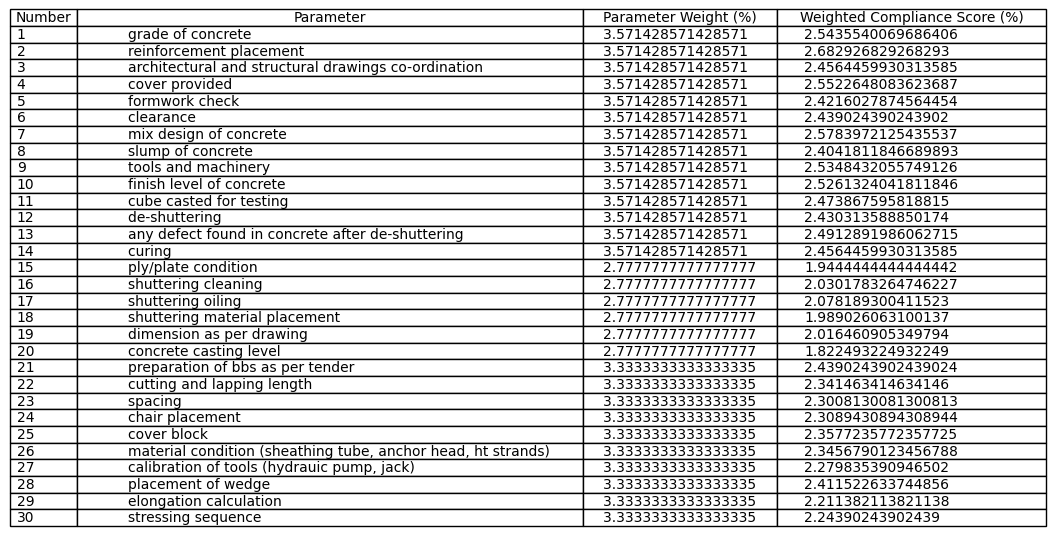

In [10]:
import matplotlib.pyplot as plt

# Step 1: Add a numbering column to the merged_df dataframe
merged_df['Number'] = range(1, len(merged_df) + 1)

# Step 2: Extract specific columns for the table chart
table_data = merged_df[['Number', merged_df.columns[1], merged_df.columns[2], 'Weighted Compliance Score (%)']]

# Create a display copy for alignment
display_table_data = table_data.copy()

# Convert relevant columns to strings and align them for display purposes
display_table_data.iloc[:, 1] = display_table_data.iloc[:, 1].astype(str).str.ljust(20)  # Align second column to the left
display_table_data.iloc[:, 2] = display_table_data.iloc[:, 2].astype(str).str.ljust(20)  # Align third column to the left

# Step 3: Create a table chart
fig, ax = plt.subplots(figsize=(12, len(display_table_data) * 0.15))  # Adjust height based on the number of rows
ax.axis('tight')
ax.axis('off')

# Create the table
table = ax.table(cellText=display_table_data.values, colLabels=table_data.columns, loc='center', cellLoc='left')

# Customize the table appearance
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(display_table_data.columns))))

# Save the table chart with cropping
plt.savefig('Weighted Compliance Score (%) Summary Table.png', dpi=300, bbox_inches='tight')  # Crop to table boundaries
plt.show()


### **Calculating Overall Project Quality Assurance Score (%)**

In [11]:
import pandas as pd

# Calculate the sum of the last column of the merged_df dataframe
final_project_quality_assurance_score = merged_df.iloc[:, 5].sum()

# Print the sum
print("Overall Project Quality Assurance Score (%):", final_project_quality_assurance_score)


# Step 1: Load the lookup table from Sheet 1 (Columns K to N)
grading_data = pd.read_excel(excel_file_path, sheet_name=0, usecols=[10, 11, 12, 13])  # K, L, M, N are columns 10-13 (zero-indexed)
grading_data.columns = ['Grade Scale', 'Lower Limit', 'Upper Limit', 'Grade Quality Description']

# Drop rows with missing values
grading_data = grading_data.dropna()

# Step 2: Compare the final_project_quality_assurance_score across the grading ranges
final_score = final_project_quality_assurance_score/100

# Find the row where the final score falls inclusively within the range
matching_row = grading_data[(grading_data['Lower Limit'] <= final_score) & (grading_data['Upper Limit'] >= final_score)]

# Step 3: If a matching row is found, return the corresponding values in columns K and N
if not matching_row.empty:
    grade_scale = matching_row.iloc[0]['Grade Scale']
    grade_quality = matching_row.iloc[0]['Grade Quality Description']
    print("Grade Scale:", grade_scale)
    print("Grade Quality Description:", grade_quality)
else:
    print("The final project quality assurance score does not fall within any defined grading range.")


Overall Project Quality Assurance Score (%): 70.11237053287641
Grade Scale: C
Grade Quality Description: Average


### **Overall Project Rating Summary Table**

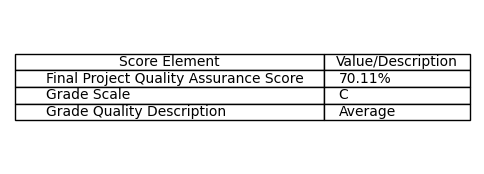

In [12]:
import matplotlib.pyplot as plt

# Check if a matching row exists and prepare the data for the table chart
if not matching_row.empty:
    grade_scale = matching_row.iloc[0]['Grade Scale']
    grade_quality = matching_row.iloc[0]['Grade Quality Description']

    # Prepare data for the table chart
    table_data = {
        "Score Element": ["Final Project Quality Assurance Score", "Grade Scale", "Grade Quality Description"],
        "Value/Description": [f"{final_project_quality_assurance_score:.2f}%", grade_scale, grade_quality]
    }

    # Create a DataFrame for visualization
    results_df = pd.DataFrame(table_data)

    # Generate the table chart
    fig, ax = plt.subplots(figsize=(6, 2))  # Adjust size as needed
    ax.axis('tight')
    ax.axis('off')

    # Create the table
    table = ax.table(cellText=results_df.values, colLabels=results_df.columns, loc='center', cellLoc='left')

    # Customize the table appearance
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.auto_set_column_width(col=list(range(len(results_df.columns))))

    # Show the table chart
    plt.savefig('Overall Project Rating Summary Table.png')  # Save the table chart
    plt.show()
else:
    print("The final project quality assurance score does not fall within any defined grading range.")


# **Machine Learning Model**

## **Prediction Model**

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


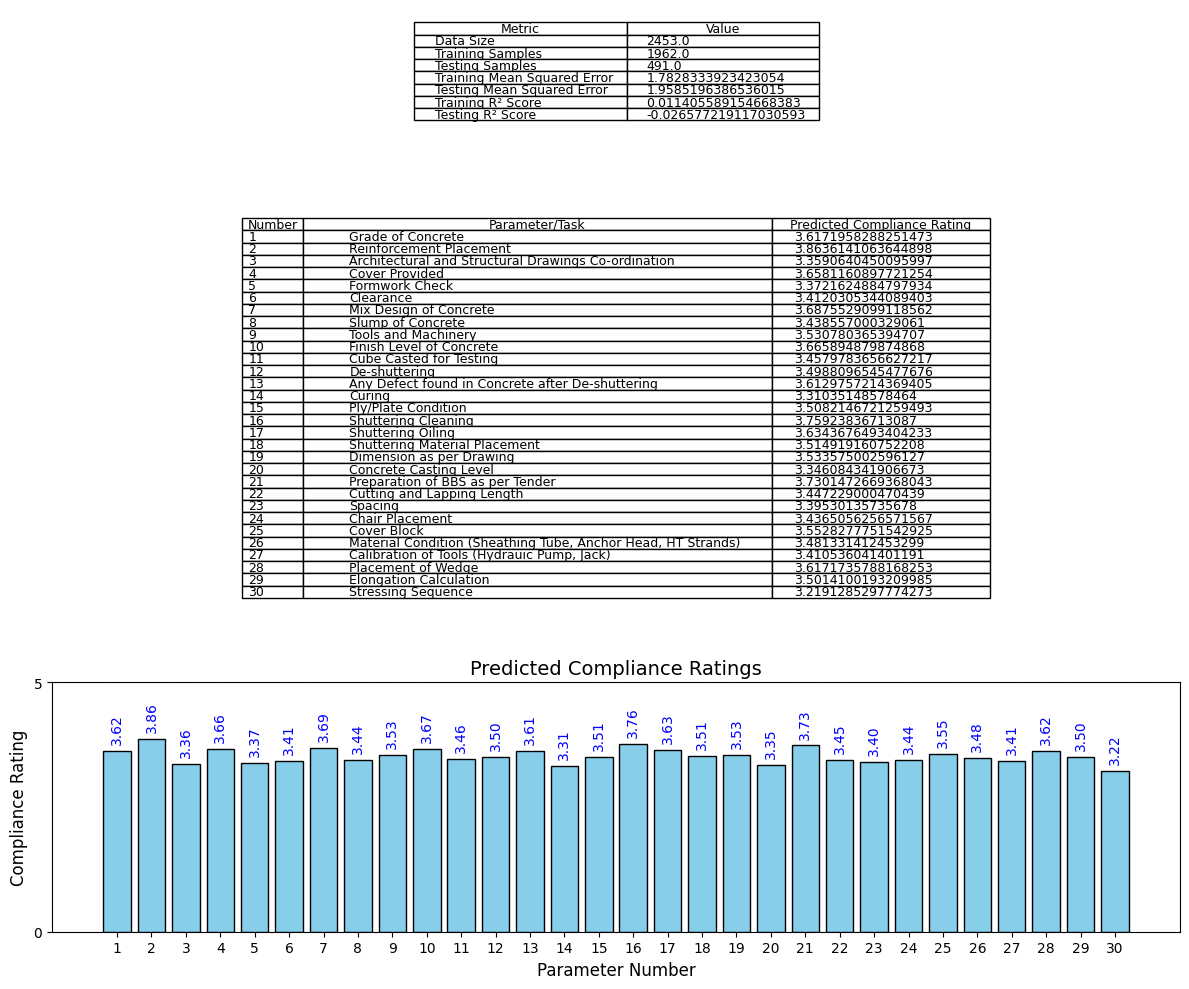

In [13]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_excel(excel_file_path, sheet_name=1, usecols=[2, 4])  # Columns C and E
data.columns = ['C', 'E']

# Drop rows with missing values
data = data.dropna()

# Encode categorical column C to numerical values
label_encoder = LabelEncoder()
data['C_encoded'] = label_encoder.fit_transform(data['C'])

# Prepare features (X) and target (y)
X = data[['C_encoded']]
y = data['E']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Instantiate and train the model
model = RandomForestRegressor(n_estimators=100, random_state=0)
model.fit(X_train, y_train)

# Predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Metrics
data_size = len(data)
training_samples = len(X_train)
testing_samples = len(X_test)
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

# Create a DataFrame for metrics
metrics = pd.DataFrame({
    'Metric': [
        'Data Size',
        'Training Samples',
        'Testing Samples',
        'Training Mean Squared Error',
        'Testing Mean Squared Error',
        'Training R² Score',
        'Testing R² Score'
    ],
    'Value': [data_size, training_samples, testing_samples, mse_train, mse_test, r2_train, r2_test]
})

# Predict a value for each unique label in column C
unique_labels = data['C'].unique()
unique_labels_encoded = label_encoder.transform(unique_labels)
predicted_values = model.predict(unique_labels_encoded.reshape(-1, 1))

# Create a DataFrame for predictions
predictions = pd.DataFrame({
    'Number': range(1, len(unique_labels) + 1),  # Add numbering column starting from 1
    'Parameter/Task': unique_labels,
    'Predicted Compliance Rating': predicted_values
})

# Plot tables and histogram
fig, axs = plt.subplots(3, 1, figsize=(12, 10), gridspec_kw={'height_ratios': [1, 1, 2]})

# Table 1: Metrics
axs[0].axis('tight')
axs[0].axis('off')
metrics_table = axs[0].table(cellText=metrics.values, colLabels=metrics.columns, loc='center', cellLoc='left')
metrics_table.auto_set_font_size(False)
metrics_table.set_fontsize(9)
metrics_table.auto_set_column_width(col=list(range(len(metrics.columns))))

# Table 2: Predictions
axs[1].axis('tight')
axs[1].axis('off')
predictions_table = axs[1].table(cellText=predictions.values, colLabels=predictions.columns, loc='center', cellLoc='left')
predictions_table.auto_set_font_size(False)
predictions_table.set_fontsize(9)
predictions_table.auto_set_column_width(col=list(range(len(predictions.columns))))


# Histogram: Plot predicted values with numbering from table 2 as x-axis labels
axs[2].bar(predictions['Number'], predictions['Predicted Compliance Rating'], color='skyblue', edgecolor='black')

# Annotate the bars of the histogram with rotated values
for i, value in enumerate(predictions['Predicted Compliance Rating']):
    axs[2].text(predictions['Number'][i], value + 0.2, f'{value:.2f}', ha='center', rotation=90, fontsize=10, color='blue')

# Add labels and title to the histogram
axs[2].set_xlabel('Parameter Number', fontsize=12)
axs[2].set_ylabel('Compliance Rating', fontsize=12)
axs[2].set_title('Predicted Compliance Ratings', fontsize=14)

# Set X-axis ticks with an interval of 1
axs[2].set_xticks(range(1, len(predictions['Number']) + 1))

# Adjust y-axis scale to increments of 5
y_max = int(predictions['Predicted Compliance Rating'].max()) + 1
axs[2].set_yticks(range(0, y_max + 5, 5))
axs[2].grid(axis='y', linestyle='--', alpha=0.7)

# Final layout adjustments
plt.tight_layout()
plt.savefig('MLM_Predictions_Summary.png', dpi=300, bbox_inches='tight', orientation='portrait')  # Save with cropping and portrait orientation
plt.show()

##**Prediction Model Analysis**

### **Residual Analysis**
Analyzing the residuals (difference between predicted and actual values) to check for patterns or issues.
Ideally, residuals should be randomly distributed with a mean of zero.

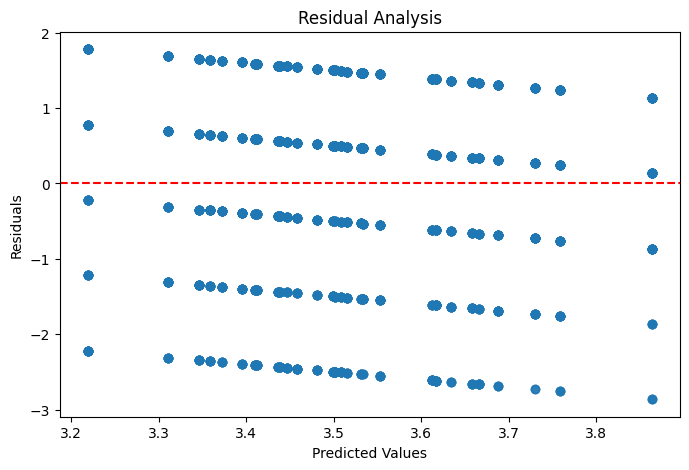

In [14]:
residuals = y - model.predict(X)
plt.figure(figsize=(8, 5))
plt.scatter(model.predict(X), residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Analysis')
plt.savefig('MLM Residual Analysis.png')  # Save the table chart
plt.show()


### **Prediction Distribution**
Compare the distribution of predicted values to the actual target values. This can show how well the model captures the overall data distribution.

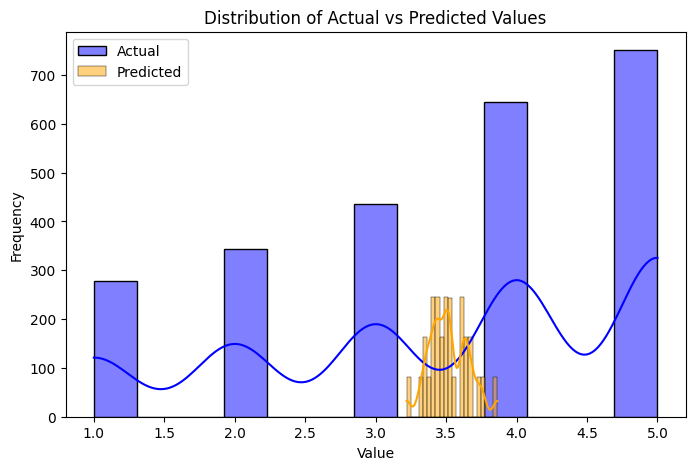

In [15]:
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(y, label='Actual', kde=True, color='blue', alpha=0.5)
sns.histplot(model.predict(X), label='Predicted', kde=True, color='orange', alpha=0.5)
plt.legend()
plt.title('Distribution of Actual vs Predicted Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.savefig('MLM Distribution of Actual vs Predicted Values.png')  # Save the table chart
plt.show()


### **Outlier Detection**
Investigate potential outliers in the predictions that may indicate model issues or data irregularities.

In [16]:
residuals = y - model.predict(X)
outliers = data[np.abs(residuals) > 2 * residuals.std()]
print("Potential Outliers:")
print(outliers)


Potential Outliers:
                                     C  E  C_encoded
140   Preparation of BBS as per Tender  1         21
195                Shuttering Cleaning  1         23
200   Preparation of BBS as per Tender  1         21
705                Shuttering Cleaning  1         23
781            Reinforcement Placement  1         22
885                Shuttering Cleaning  1         23
1171           Reinforcement Placement  1         22
1261           Reinforcement Placement  1         22
1580  Preparation of BBS as per Tender  1         21
1605               Shuttering Cleaning  1         23
1725               Shuttering Cleaning  1         23
2398           Reinforcement Placement  1         22


### **Cross-Validation**
Using cross-validation to assess the model's performance more robustly across different subsets of the data.

In [17]:
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
print(f"Cross-Validation R² Scores: {cv_scores}")
print(f"Mean CV R² Score: {cv_scores.mean()}")


Cross-Validation R² Scores: [-0.01818039 -0.01703368 -0.02969916 -0.02357167 -0.09072416]
Mean CV R² Score: -0.035841812354590274


### **SHAP Values**
Use SHAP (SHapley Additive exPlanations) to understand the impact of each feature on individual predictions.

 95%|=================== | 2329/2453 [00:12<00:00]       

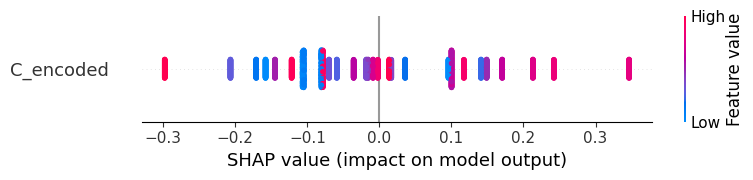

In [18]:
import shap
import matplotlib.pyplot as plt

# Generate SHAP explainer and values
explainer = shap.Explainer(model, X)
shap_values = explainer(X)

# Create SHAP summary plot
shap.summary_plot(shap_values, X, show=False)  # Generate the plot without displaying

# Save the SHAP summary plot as a PNG file
fig = plt.gcf()  # Get the current figure
fig.savefig("MLM_SHAP_Values.png", dpi=300, bbox_inches='tight')  # Save with high quality



### **Prediction Uncertainty**
Assess how certain the model is about its predictions using variance or confidence intervals from ensembles.

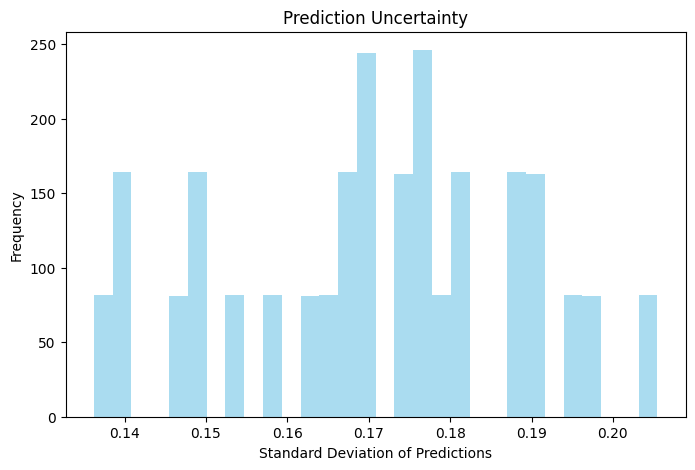

In [19]:
# Convert X to numpy array for prediction to avoid warnings
predictions = [tree.predict(X.values) for tree in model.estimators_]

# Calculate the standard deviation of predictions
prediction_std = np.std(predictions, axis=0)

# Plot the histogram of prediction uncertainties
plt.figure(figsize=(8, 5))
plt.hist(prediction_std, bins=30, color='skyblue', alpha=0.7)
plt.title('Prediction Uncertainty')
plt.xlabel('Standard Deviation of Predictions')
plt.ylabel('Frequency')
plt.savefig('MLM Prediction Uncertainty.png')  # Save the table chart
plt.show()


# **Final Report Download**

In [20]:
from matplotlib.backends.backend_pdf import PdfPages
import os
from google.colab import files
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Specify the order of PNG files
custom_order = [
    "histogram_table.png",
    "Average Assessed Compliance Ratings.png",
    "Weighted Compliance Score (%) Summary Table.png",
    "Overall Project Rating Summary Table.png",
    "MLM Predictions Summary.png",
    "MLM Residual Analysis.png",
    "MLM Distribution of Actual vs Predicted Values.png",
    "MLM Prediction Uncertainty.png",
]

# Function to compile PNG files into a PDF with dynamic orientation and scaling
def compile_png_to_pdf(pdf_filename="Final_Project_Quality_Assurance_Rating_Report.pdf", dpi=600):
    # Verify the specified files exist
    existing_files = [file for file in custom_order if os.path.exists(file)]

    if not existing_files:
        print("No valid PNG files found in the specified order.")
        return

    # Compile the PNGs into the PDF
    with PdfPages(pdf_filename) as pdf:
        for png_file in existing_files:
            print(f"Adding {png_file} to {pdf_filename}")
            # Load the image to get its dimensions
            img = mpimg.imread(png_file)
            height, width = img.shape[:2]

            # Determine orientation: portrait for taller images, landscape for wider images
            if height >= width:
                # Portrait orientation (letter size)
                fig, ax = plt.subplots(figsize=(8.5, 13))  # Standard letter size portrait
            else:
                # Landscape orientation (letter size)
                fig, ax = plt.subplots(figsize=(13, 8.5))  # Standard letter size landscape

            # Display the image
            ax.imshow(img, aspect='auto')  # Preserve aspect ratio
            ax.axis('off')  # Turn off axis

            # Save the current figure to the PDF
            pdf.savefig(fig, dpi=300)  # Save with high DPI
            plt.close(fig)  # Close the figure to free memory

    print(f"PDF file '{pdf_filename}' created successfully.")

    # Provide the PDF for download in Google Colab
    files.download(pdf_filename)

# Call the function to compile and download the PDF
compile_png_to_pdf()


Adding histogram_table.png to Final_Project_Quality_Assurance_Rating_Report.pdf
Adding Average Assessed Compliance Ratings.png to Final_Project_Quality_Assurance_Rating_Report.pdf
Adding Weighted Compliance Score (%) Summary Table.png to Final_Project_Quality_Assurance_Rating_Report.pdf
Adding Overall Project Rating Summary Table.png to Final_Project_Quality_Assurance_Rating_Report.pdf
Adding MLM Residual Analysis.png to Final_Project_Quality_Assurance_Rating_Report.pdf
Adding MLM Distribution of Actual vs Predicted Values.png to Final_Project_Quality_Assurance_Rating_Report.pdf
Adding MLM Prediction Uncertainty.png to Final_Project_Quality_Assurance_Rating_Report.pdf
PDF file 'Final_Project_Quality_Assurance_Rating_Report.pdf' created successfully.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [22]:
import os

# List of files to delete
files_to_delete = [
    "histogram_table_plot.png",
    # Add more file names you want to delete
]

# Delete the specified files
for file in files_to_delete:
    if os.path.exists(file):
        os.remove(file)
        print(f"Deleted: {file}")
    else:
        print(f"File not found: {file}")


File not found: histogram_table_plot.png
